# OBSERVATION
         1)Applying logistic regression for counterVectorizer(BOW)
         2)Evaluate the test and cv data on various performance metrics like accuracy,precision_score,recall,f1score 
         and also plotted confusion matrix by using scikitplot
         3)To find the hyperparameter by using both gridsearchcv and Randomsearchcv
         4)To show how sparsity increasing when we increase/decrease cv in l1 regularisation
         5)To check whether the features are multicollinearity or not by using pertubation method

In [2]:
import sqlite3
import pandas as pd
import numpy as np
con=sqlite3.connect("database.sqlite")
data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3""",con)
def partitions(x):
    if x < 3:
        return "negative"
    return "positive"
score=data["Score"]
positive_negative=score.map(partitions)
data["Score"]=positive_negative
#Here I am just sorting the data
sorted_data=data.sort_values("ProductId",ascending=True,inplace=False,na_position="last")
#Here I am dropping the fake reviews (repeated reviews)
Final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)
#Again I am filtering the data by using this condition
Final_data=Final_data[Final_data.HelpfulnessNumerator <= Final_data.HelpfulnessDenominator]
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
import re
##functions to clean html and punctuation
stop=set(stopwords.words("english"))#set stop words  
snow=nltk.stem.SnowballStemmer("english")    #its give the stem word of particular word(eg:happy--happi)
def clearhtml(sentence):#In cleanhtml function we taking all the html tag by using regular expression
    cleanr=re.compile("<.*?>")
    clean=re.sub(cleanr," ",sentence)
    return clean
def clearpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
#here we just filtered the reviews ie:preprocessing the data
#1)clean the html tags in whole Final_data["Text"]
#2)clean the punctuation in whole Final_data["Text"] by word by word('w')
#3)check whether its alphabet or not and also length of the word should be more than 2
#4)And change it into lower case and check  those words are not in stop word if its in stopwords its eliminate it
#5)And we stemming each word and encode it

i=0
str=' '
clean_string=[]
positive_word=[]
negative_word=[]
for stem in Final_data["Text"]:
    Filtered_word=[]
    stem=clearhtml(stem)
    #print(stem)
    for word in stem.split():
        for clean_word in clearpunc(word).split():
            if clean_word.isalpha() and len(clean_word) >2:
                if clean_word.lower() not in stop:
                    s=snow.stem(clean_word.lower()).encode("utf8")
                    Filtered_word.append(s)
                    if (Final_data["Score"].values)[i] == "positive":
                        positive_word.append(s)
                    if(Final_data["Score"].values)[i]  == "negative":
                        negative_word.append(s)
                else:
                    continue
            else:
                continue
    str1=b" ".join(Filtered_word)
    clean_string.append(str1)
    i+=1
Final_data["cleaned_data"]=clean_string
Final_data["cleaned_data"]=Final_data["cleaned_data"].str.decode('utf8')
#sorting my dataframe in TBS
import datetime

Final_data["Time"] = Final_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))
sorted_data=Final_data.sort_values("Time",ascending=True,kind="quicksort",inplace=False,axis=0).reset_index(drop=True)


In [3]:
data_40k=sorted_data.head(150000)
data_40k['Score'].value_counts()

positive    129547
negative     20453
Name: Score, dtype: int64

In [4]:
def partitions(x):
    if x=="positive":
        return 1
    return 0
score=data_40k["Score"]
positive_negative=score.map(partitions)
data_40k["Score"]=positive_negative

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
#Here I am just splitting my data into train,cv and test sets
X_train, X_test, y_train, y_test = train_test_split(data_40k,data_40k['Score'],test_size=0.3,random_state=42,shuffle=False)
X_tr,X_cv,y_tr,y_cv=train_test_split(X_train,y_train,test_size=0.3,shuffle=False)
#print(X_tr.shape)
#print(X_test.shape)
#print(X_cv.shape)

# BOW(UNIGRAM) 

In [7]:
#here I am using Counter vectorizer(BOW(unigram)) to convert the text into vectors
cnt_vector=CountVectorizer()
fit_Xtrain=cnt_vector.fit(X_tr["cleaned_data"])#fit the counter vectorizer only on train data
trans_Xtrain=cnt_vector.transform(X_tr["cleaned_data"])#transform the fitted data to new variables(train,test,cv)
trans_Xtest=cnt_vector.transform(X_test["cleaned_data"])
trans_Xcv=cnt_vector.transform(X_cv["cleaned_data"])
trans_Xtest.shape

(45000, 32066)

In [8]:
from sklearn.preprocessing import StandardScaler
std_bow=StandardScaler(with_mean=False)
std_bow.fit(trans_Xtrain)
X_train_stnd2=std_bow.transform(trans_Xtrain)
X_test_stnd2=std_bow.transform(trans_Xtest)
X_cv_stnd2=std_bow.transform(trans_Xcv)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced')
#params we need to try on classifier
param=[]
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l2']}               #here I am using l2 norm
gsv = GridSearchCV(clf,param_grid,cv=5,scoring="f1",n_jobs=-1)#grid_search is used to find the best optimal C
gsv.fit(X_train_stnd2,y_tr)#fit the model only in train dataset
print("Best HyperParameter: ",gsv.best_params_)#the attributes best_params_ gives the Best hyper parameter value
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))#the attribute best_score_ gives the Accuracy of the grid search which gives best C through logistic regression
param.append(gsv.best_params_)
C1=param[0]["C"]
#print(C1)

Best HyperParameter:  {'C': 0.0001, 'penalty': 'l2'}
Best Accuracy: 94.53%


In [10]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import seaborn as sns
import scikitplot.metrics as sklpt

clf = LogisticRegression(C=C1, penalty= 'l2',class_weight="balanced")#Here I am using L2 norm
clf.fit(X_train_stnd2,y_tr)
y_pred = clf.predict(X_cv_stnd2)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
sklpt.plot_confusion_matrix(y_cv,y_pred)

Accuracy on cv set: 89.686%
Precision on cv set: 91.238
Recall on cv set: 89.686
F1-Score on cv set: 90.243
Non Zero weights: 32066


K value in Kfold is: 0.0001


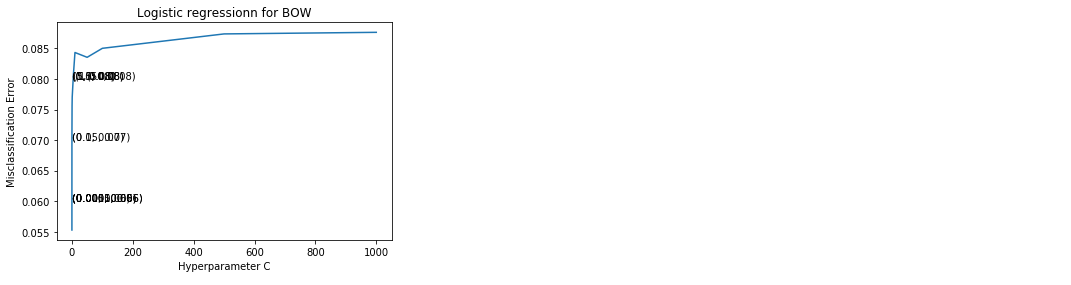

In [11]:
#We gonna find the optimal k by using K fold
cv_score=[]
mylist=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
for k in mylist:# my list contains odd from 1 to 30
    lr=LogisticRegression(C=k,class_weight="balanced")
    score=cross_val_score(lr,X_train_stnd2,y_tr,cv=10,scoring="f1")#here i am using my X and Y as X_tr and y_tr
    #print(score)
    cv_score.append(score.mean())#score gives as 10 score for each odd numbers so we should take score.mean()and store it in cv_score
import matplotlib.pyplot as plt
#print(cv_score)
MSE=[1-x for x in cv_score]
optimal_k = mylist[MSE.index(min(MSE))]
print("K value in Kfold is:",optimal_k)
plt.plot(mylist,MSE)
for xy in zip(mylist, np.round(MSE,2)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel("Hyperparameter C")
plt.ylabel("Misclassification Error")
plt.title("Logistic regressionn for BOW")
plt.show()

In [12]:
print(classification_report(y_cv, y_pred))#classification report gives the report of accuracy score,precision score,recall,f1score
cv_acc=confusion_matrix(y_cv,y_pred)
print(cv_acc)
tn, fp, fn, tp = confusion_matrix(y_cv,y_pred).ravel()
print("true negative:",tn)
print("false positive: ",fp)
print("false negative :",fn)
print("true positive ",tp)


             precision    recall  f1-score   support

          0       0.60      0.78      0.68      4338
          1       0.96      0.92      0.94     27162

avg / total       0.91      0.90      0.90     31500

[[ 3380   958]
 [ 2291 24871]]
true negative: 3380
false positive:  958
false negative : 2291
true positive  24871


Accuracy on test set: 88.822%
Precision on test set: 90.204
Recall on test set: 88.822
F1-Score on test set: 89.309
Non Zero weights: 32066


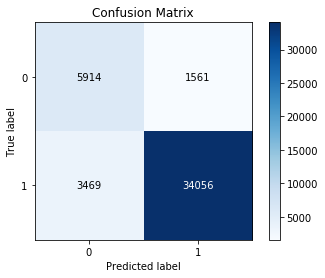

In [13]:
#metrics Score for test
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import seaborn as sns


clf = LogisticRegression(C= C1, penalty= 'l2',class_weight="balanced")
clf.fit(X_train_stnd2,y_tr)
y_pred = clf.predict(X_test_stnd2)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))#it counts the no of non zero features
sklpt.plot_confusion_matrix(y_test,y_pred)#plotting the confusion matrix for ytest and y_pred

# How Sparsity is differ if we change the C value(hyperparameter)

In [14]:

import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import seaborn as sns


clf = LogisticRegression(C= 10, penalty= 'l1',class_weight="balanced")#Here I am using L1 norms
clf.fit(X_train_stnd2,y_tr)
y_pred = clf.predict(X_test_stnd2)
coef_=clf.coef_
print("Non Zero weights:",np.count_nonzero(coef_))#basically l1 norms gives high sparsity so no of non zero will be low


Non Zero weights: 16274


In [15]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import seaborn as sns


clf = LogisticRegression(C= 100, penalty= 'l1',class_weight="balanced")#HereI am changing the hyper parameter value so no of non zero values gets differ from above
clf.fit(X_train_stnd2,y_tr)
y_pred = clf.predict(X_test_stnd2)
print("Non Zero weights:",np.count_nonzero(clf.coef_))


Non Zero weights: 21238


In [16]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import seaborn as sns


clf = LogisticRegression(C= 0.1, penalty= 'l1')#Here hyperparameter value C is very low so the non zero value will be very low
clf.fit(X_train_stnd2,y_tr)
y_pred = clf.predict(X_test_stnd2)
print("Non Zero weights:",np.count_nonzero(clf.coef_))


Non Zero weights: 10033


# pertubation test

In [17]:
#just checking the accuracy before adding random noise 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_stnd2,y_tr)
y_pred = clf.predict(X_test_stnd2)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Before adding r.noise Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 85.567%
Before adding r.noise Non Zero weights: 32066


In [18]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1.size)
print(weights1[:50])
#print(weights1[0:2])
#print(clf.coef_[0])

32066
[-4.44567088e-03  9.27238087e-03  1.82728241e-03 -5.57272412e-03
 -1.30701231e-02  1.04726596e-03 -1.55899112e-02 -8.13897763e-03
 -2.24731889e-03  4.28899439e-01 -3.73893606e-03  1.28549116e-02
 -2.30015475e-03  5.93838800e-04  1.19706490e-01 -8.72309348e-02
  7.18183830e-02  4.17253008e-02 -1.79926304e-01  8.36760296e-03
 -3.79464618e-04  2.36223406e-02  1.37612338e-03  3.78248474e-02
 -1.10982156e-02 -1.04722070e-01 -1.53134181e-03  7.41989026e-04
 -2.08781843e-02  2.33968299e-01  2.73848145e-02 -8.92407753e-03
 -6.29227167e-04  4.13383223e-05 -8.98561106e-03 -3.68481251e-02
 -6.34209125e-03  8.58838565e-02  2.25518531e-02  1.22181851e-02
 -6.17157149e-02 -1.51463448e-03  2.71646814e-04  3.15657553e-02
  1.87317568e-01 -1.23503263e-03  5.45898487e-02 -3.27292886e-02
 -9.39057405e-04  1.14124552e-02]


In [19]:
X_train_t = X_train_stnd2
#Random noise
print(X_train_stnd2.size)
#print(X_train_t)
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size))
#Getting the postions(row and column) and value of non-zero datapoints 
#print(find(X_train_t)[0].size)
a,b,c = find(X_train_t)#a contains row indices b contains column indices c contains non zero matrix entries
#print(a)
#print(b)
#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]


2199282


In [20]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_tr)
y_pred = clf.predict(X_test_stnd2)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 85.573%
Non Zero weights: 32066


In [21]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])
print(weights2.size)
weights_diff = ((weights1 - weights2) /weights1)*100
#for i in range(weights_diff.size):
  #  print(np.round_(weights_diff[i],decimals=2))
#weights_diff = (weights1 + weights2) 
#print(weights_diff.shape)
print(weights_diff[np.where(weights_diff > 40)].size)

[-7.23889308e-03  9.27329125e-03  1.68861223e-03 -6.62002329e-03
 -1.59009016e-02  1.53097892e-03 -1.57126003e-02 -1.14922356e-02
 -2.80819031e-03  4.29238119e-01 -2.93376056e-03  1.27729803e-02
 -2.83238614e-03  1.68354739e-03  1.18988633e-01 -8.71686068e-02
  7.07752233e-02  4.28708583e-02 -1.79204042e-01  8.36496725e-03
 -1.85164262e-04  2.36247738e-02  2.50691438e-03  3.73297191e-02
 -1.58119545e-02 -1.04768419e-01 -2.16184753e-04  3.93783394e-04
 -2.04823982e-02  2.34506350e-01  2.74339520e-02 -1.68768803e-02
 -8.34138378e-04  1.35322302e-03 -1.23985267e-02 -3.70192482e-02
 -8.80371248e-03  8.59981585e-02  2.26381447e-02  1.25831935e-02
 -6.17056090e-02 -2.69111788e-03  1.92386441e-04  3.28017547e-02
  1.87381816e-01 -1.38765250e-03  5.52532072e-02 -3.47164902e-02
 -1.67199396e-03  1.06641668e-02]
32066
1020


In [22]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
show_most_informative_features(cnt_vector,clf)
#code_reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-1.6153	author         				3.9814	mole           
	-1.4885	kretschmer     				2.3109	yum            
	-1.4649	parasit        				1.9888	great          
	-1.4247	que            				1.9591	best           
	-1.1102	penetr         				1.9165	sin            
	-1.0756	geyser         				1.8487	languag        
	-1.0569	www            				1.7709	plaqu          
	-1.0566	marco          				1.6906	scovill        
	-1.0426	independ       				1.6543	heartili       
	-1.0338	context        				1.6062	activ          
	-1.0076	insuffici      				1.5817	cacao          
	-1.0065	bacteria       				1.5361	love           
	-0.9587	worst          				1.5357	relax          
	-0.8948	agricultur     				1.4880	yerba          
	-0.8530	physiolog      				1.3192	petit          
	-0.8443	infrequ        				1.2913	towel          
	-0.8378	stool          				1.2872	perfect        
	-0.8278	i

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2',class_weight="balanced")
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
rsv = RandomizedSearchCV(clf,param_grid,cv=5,verbose=0)
rsv.fit(X_train_stnd2,y_tr)
print("Best HyperParameter: ",rsv.best_params_)
print("Best Accuracy: %.2f%%"%(rsv.best_score_*100))
#print("Non Zero weights:",np.count_nonzero(clf.coef_))


Best HyperParameter:  {'C': 0.0001}
Best Accuracy: 90.54%


# BIGRAM

In [24]:
cnt_vector_bigram=CountVectorizer(ngram_range=(1,2))
fit_Xtrain=cnt_vector_bigram.fit(X_tr["cleaned_data"])
trans_Xtrain=cnt_vector_bigram.transform(X_tr["cleaned_data"])
trans_Xtest=cnt_vector_bigram.transform(X_test["cleaned_data"])
trans_Xcv=cnt_vector_bigram.transform(X_cv["cleaned_data"])
#print(trans_Xtest.shape)
#print(trans_Xcv.shape)
#print(trans_Xtrain.shape)

In [25]:
from sklearn.preprocessing import StandardScaler
std_bigram=StandardScaler(with_mean=False)
std_bigram.fit(trans_Xtrain)
X_train_stnd2=std_bigram.transform(trans_Xtrain)
X_test_stnd2=std_bigram.transform(trans_Xtest)
X_cv_stnd2=std_bigram.transform(trans_Xcv)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced')
#params we need to try on classifier
param=[]
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l2']}               #here I am using l2 norm
gsv = GridSearchCV(clf,param_grid,cv=10,scoring="f1")#grid_search is used to find the best optimal C
gsv.fit(X_train_stnd2,y_tr)#fit the model only in train dataset
print("Best HyperParameter: ",gsv.best_params_)#the attributes best_params_ gives the Best hyper parameter value
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))#the attribute best_score_ gives the Accuracy of the grid search which gives best C through logistic regression
#print(y_tr.value_counts())
#print(X_tr['Score'].value_counts())
param.append(gsv.best_params_)
C1=param[0]["C"]

Best HyperParameter:  {'C': 0.0001, 'penalty': 'l2'}
Best Accuracy: 94.88%


Accuracy on cv set: 89.314%
Precision on cv set: 88.961
Recall on cv set: 89.314
F1-Score on cv set: 86.800
logloss on cv set: 3.691%
Non Zero weights: 951401


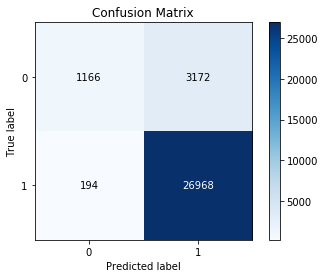

In [27]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,log_loss
import seaborn as sns


clf = LogisticRegression(C=C1 ,penalty= 'l2',class_weight="balanced")#Here I am using L2 norm
clf.fit(X_train_stnd2,y_tr)
y_pred = clf.predict(X_cv_stnd2)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("logloss on cv set: %0.3f%%"%(log_loss(y_cv, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
skplt.plot_confusion_matrix(y_cv,y_pred)

K value in Kfold is: 0.0001


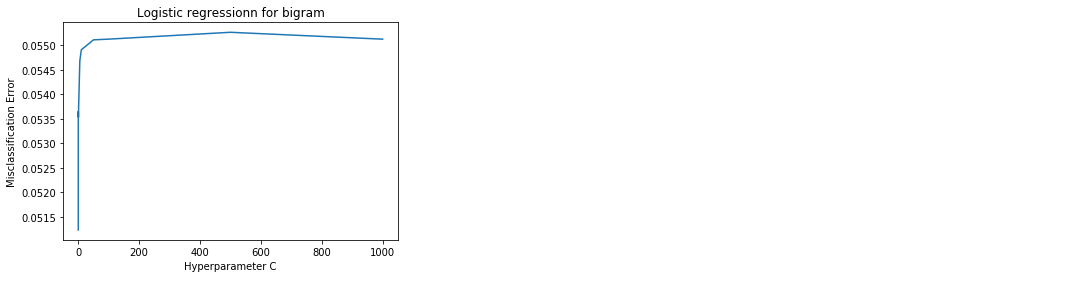

In [28]:
#We gonna find the optimal k by using K fold
cv_score=[]
mylist=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
for k in mylist:# my list contains odd from 1 to 30
    lr=LogisticRegression(C=k,class_weight="balanced")
    score=cross_val_score(lr,X_train_stnd2,y_tr,cv=10,scoring="f1")#here i am using my X and Y as X_tr and y_tr
    #print(score)
    cv_score.append(score.mean())#score gives as 10 score for each odd numbers so we should take score.mean()and store it in cv_score
import matplotlib.pyplot as plt
#print(cv_score)
MSE=[1-x for x in cv_score]
optimal_k = mylist[MSE.index(min(MSE))]
print("K value in Kfold is:",optimal_k)
plt.plot(mylist,MSE)
for xy in zip(mylist, np.round(MSE,2)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel("Hyperparameter C")
plt.ylabel("Misclassification Error")
plt.title("Logistic regressionn for bigram")
plt.show()

In [29]:
print(classification_report(y_cv, y_pred))#classification report gives the report of accuracy score,precision score,recall,f1score
cv_acc=confusion_matrix(y_cv,y_pred)
print(cv_acc)
tn, fp, fn, tp = confusion_matrix(y_cv,y_pred).ravel()
print("true negative:",tn)
print("false positive: ",fp)
print("false negative :",fn)
print("true positive ",tp)

             precision    recall  f1-score   support

          0       0.86      0.27      0.41      4338
          1       0.89      0.99      0.94     27162

avg / total       0.89      0.89      0.87     31500

[[ 1166  3172]
 [  194 26968]]
true negative: 1166
false positive:  3172
false negative : 194
true positive  26968


Accuracy on test set: 85.204%
Precision on test set: 86.450
Recall on test set: 85.204
F1-Score on test set: 80.048
logloss on test set: 5.110%
Non Zero weights: 951401


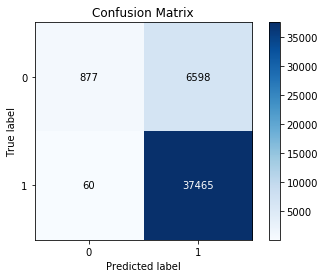

In [30]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,log_loss
import seaborn as sns


clf = LogisticRegression(C=C1 ,penalty= 'l2')#Here I am using L2 norm
clf.fit(X_train_stnd2,y_tr)
y_pred = clf.predict(X_test_stnd2)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("logloss on test set: %0.3f%%"%(log_loss(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
skplt.plot_confusion_matrix(y_test,y_pred)

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2')
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
rsv = RandomizedSearchCV(clf,param_grid,cv=5,verbose=0)
rsv.fit(X_train_stnd2,y_tr)
print("Best HyperParameter: ",rsv.best_params_)
print("Best Accuracy: %.2f%%"%(rsv.best_score_*100))
#print("Non Zero weights:",np.count_nonzero(clf.coef_))


Best HyperParameter:  {'C': 50}
Best Accuracy: 89.63%


# W2V

In [32]:
from gensim.models import Word2Vec    
from gensim.models import KeyedVectors
import pickle

i=0
list_of_sent=[]
for sent in X_tr['cleaned_data'].values:
    list_of_sent.append(sent.split())

C:\Users\Admin\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [33]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words=list(w2v_model.wv.vocab)
#print(w2v_words)

# AVGW2V

In [34]:
Avg_w2v_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_tr['cleaned_data']: 
    sent_vec = np.zeros(50)# as word vectors are of zero length
    cnt_words =0; 
    for word in sent.split(): # for each word in a review/sentence
        #print(word)
        if word in w2v_words:
            vec = w2v_model.wv[word]#wv is used to convrt word into vector
            sent_vec += vec #we adding that vector into zeros[50]
            #print(sent_vec)
            cnt_words += 1 #the valid vector increasing by 1
    if cnt_words != 0: #if its an valid vector
        sent_vec /= cnt_words
    Avg_w2v_train.append(sent_vec)
print(len(Avg_w2v_train))
print(len(Avg_w2v_train[0]))
#print(Avg_w2v_train)

73500
50


In [35]:
Avg_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_test['cleaned_data']: 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; 
    for word in sent.split(): # for each word in a review/sentence
        #print(word)
        if word in w2v_words:
            vec = w2v_model.wv[word]#wv is used to convrt word into vector
            sent_vec += vec #we adding that vector into zeros[50]
            cnt_words += 1 #the valid vector increasing by 1
    if cnt_words != 0: #if its an valid vector
        sent_vec /= cnt_words
    Avg_w2v_test.append(sent_vec)
print(len(Avg_w2v_test))
print(len(Avg_w2v_test[0]))

45000
50


In [36]:
Avg_w2v_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_cv['cleaned_data']: 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; 
    for word in sent.split(): # for each word in a review/sentence
        #print(word)
        if word in w2v_words:
            vec = w2v_model.wv[word]#wv is used to convrt word into vector
            sent_vec += vec #we adding that vector into zeros[50]
            cnt_words += 1 #the valid vector increasing by 1
    if cnt_words != 0: #if its an valid vector
        sent_vec /= cnt_words
    Avg_w2v_cv.append(sent_vec)
print(len(Avg_w2v_cv))
print(len(Avg_w2v_cv[0]))
#print(Avg_w2v_cv)

31500
50


In [37]:
from sklearn.preprocessing import StandardScaler
std_avg=StandardScaler(with_mean=False)
std_avg.fit(Avg_w2v_train)
X_train_stnd2=std_avg.transform(Avg_w2v_train)
X_test_stnd2=std_avg.transform(Avg_w2v_test)
X_cv_stnd2=std_avg.transform(Avg_w2v_cv)

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced')
#params we need to try on classifier
params=[]
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l2']}               #here I am using l2 norm
gsv = GridSearchCV(clf,param_grid,cv=10,scoring="f1")#grid_search is used to find the best optimal C
gsv.fit(X_train_stnd2,y_tr)#fit the model only in train dataset
print("Best HyperParameter: ",gsv.best_params_)#the attributes best_params_ gives the Best hyper parameter value
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))#the attribute best_score_ gives the Accuracy of the grid search which gives best C through logistic regression
#print(y_tr.value_counts())
#print(X_tr['Score'].value_counts())
params.append(gsv.best_params_)
C1=params[0]["C"]

Best HyperParameter:  {'C': 0.05, 'penalty': 'l2'}
Best Accuracy: 88.03%


Accuracy on cv set: 89.606%
Precision on cv set: 88.463
Recall on cv set: 89.606
F1-Score on cv set: 88.169
logloss on cv set: 3.590%
Non Zero weights: 50


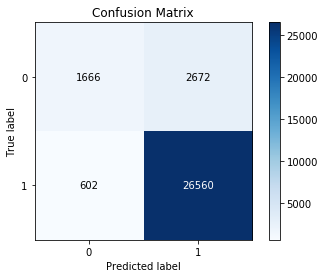

In [39]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,log_loss
import seaborn as sns


clf = LogisticRegression(C=C1 ,penalty= 'l2')#Here I am using L2 norm
clf.fit(X_train_stnd2,y_tr)
y_pred = clf.predict(X_cv_stnd2)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("logloss on cv set: %0.3f%%"%(log_loss(y_cv, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
skplt.plot_confusion_matrix(y_cv,y_pred)

K value in Kfold is: 0.05


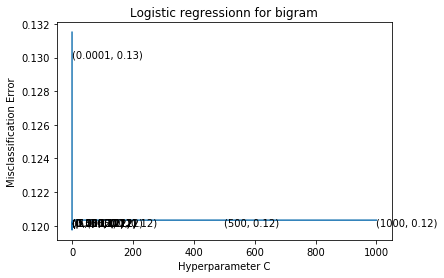

In [40]:
#We gonna find the optimal k by using K fold
cv_score=[]
mylist=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
for k in mylist:# my list contains odd from 1 to 30
    lr=LogisticRegression(C=k,class_weight="balanced")
    score=cross_val_score(lr,X_train_stnd2,y_tr,cv=10,scoring="f1")#here i am using my X and Y as X_tr and y_tr
    #print(score)
    cv_score.append(score.mean())#score gives as 10 score for each odd numbers so we should take score.mean()and store it in cv_score
import matplotlib.pyplot as plt
#print(cv_score)
MSE=[1-x for x in cv_score]
optimal_k = mylist[MSE.index(min(MSE))]
print("K value in Kfold is:",optimal_k)
plt.plot(mylist,MSE)
for xy in zip(mylist, np.round(MSE,2)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel("Hyperparameter C")
plt.ylabel("Misclassification Error")
plt.title("Logistic regressionn for bigram")
plt.show()

Accuracy on test set: 87.811%
Precision on test set: 86.755
Recall on test set: 87.811
F1-Score on test set: 86.145
logloss on test set: 4.210%
Non Zero weights: 50


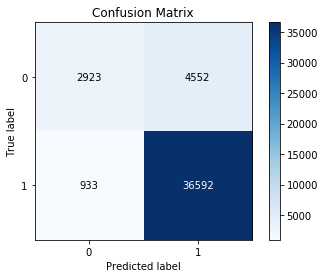

In [41]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,log_loss
import seaborn as sns


clf = LogisticRegression(C=0.05 ,penalty= 'l2')#Here I am using L2 norm
clf.fit(X_train_stnd2,y_tr)
y_pred = clf.predict(X_test_stnd2)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("logloss on test set: %0.3f%%"%(log_loss(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
skplt.plot_confusion_matrix(y_test,y_pred)

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2')
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
rsv = RandomizedSearchCV(clf,param_grid,cv=5,verbose=0)
rsv.fit(X_train_stnd2,y_tr)
print("Best HyperParameter: ",rsv.best_params_)
print("Best Accuracy: %.2f%%"%(rsv.best_score_*100))
#print("Non Zero weights:",np.count_nonzero(clf.coef_))


Best HyperParameter:  {'C': 0.1}
Best Accuracy: 90.78%


# TFIDF

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer  #tf is calculated by no of wi occurs in rj/no of words in rj 
from sklearn.feature_extraction.text import TfidfVectorizer    #idf is calculated by no of docs/docs which contains wi                                                 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))#tfidf=tf*idf
final_tfidf = tf_idf_vect.fit(X_tr["cleaned_data"].values)
tfidf_train=tf_idf_vect.transform(X_tr["cleaned_data"])
tfidf_test=tf_idf_vect.transform(X_test["cleaned_data"])
tfidf_cv=tf_idf_vect.transform(X_cv["cleaned_data"])

In [44]:
from sklearn.preprocessing import StandardScaler
std_tfidf=StandardScaler(with_mean=False)
std_tfidf.fit(tfidf_train)
stnd_data_tfidf=std_tfidf.transform(tfidf_train)
stnd_data_tfidf_test=std_tfidf.transform(tfidf_test)
stnd_data_tfidf_cv=std_tfidf.transform(tfidf_cv)


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced')
#params we need to try on classifier
params=[]
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l2']}               #here I am using l2 norm
gsv = GridSearchCV(clf,param_grid,cv=10,scoring="f1")#grid_search is used to find the best optimal C
gsv.fit(stnd_data_tfidf,y_tr)#fit the model only in train dataset
print("Best HyperParameter: ",gsv.best_params_)#the attributes best_params_ gives the Best hyper parameter value
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))#the attribute best_score_ gives the Accuracy of the grid search which gives best C through logistic regression
#print(y_tr.value_counts())
#print(X_tr['Score'].value_counts())
params.append(gsv.best_params_)
C1=params[0]["C"]

Best HyperParameter:  {'C': 0.0001, 'penalty': 'l2'}
Best Accuracy: 94.73%


Accuracy on cv set: 89.102%
Precision on cv set: 88.891
Recall on cv set: 89.102
F1-Score on cv set: 86.342
logloss on cv set: 3.764%
Non Zero weights: 951401


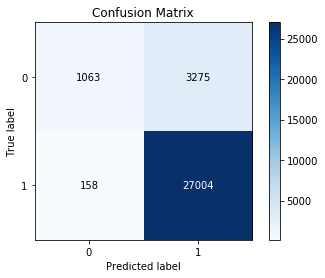

In [46]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,log_loss
import seaborn as sns


clf = LogisticRegression(C=C1 ,penalty= 'l2',class_weight="balanced")#Here I am using L2 norm
clf.fit(stnd_data_tfidf,y_tr)
y_pred = clf.predict(stnd_data_tfidf_cv)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("logloss on cv set: %0.3f%%"%(log_loss(y_cv, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
skplt.plot_confusion_matrix(y_cv,y_pred)

K value in Kfold is: 0.0001


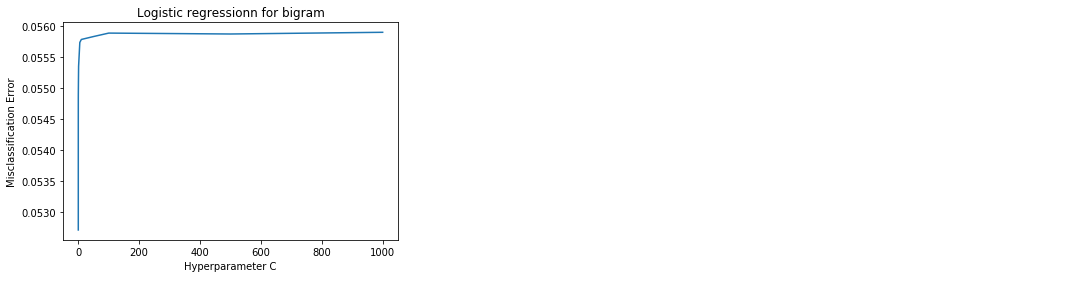

In [47]:
#We gonna find the optimal k by using K fold
cv_score=[]
mylist=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
for k in mylist:# my list contains odd from 1 to 30
    lr=LogisticRegression(C=k,class_weight="balanced")
    score=cross_val_score(lr,stnd_data_tfidf,y_tr,cv=10,scoring="f1")#here i am using my X and Y as X_tr and y_tr
    #print(score)
    cv_score.append(score.mean())#score gives as 10 score for each odd numbers so we should take score.mean()and store it in cv_score
import matplotlib.pyplot as plt
#print(cv_score)
MSE=[1-x for x in cv_score]
optimal_k = mylist[MSE.index(min(MSE))]
print("K value in Kfold is:",optimal_k)
plt.plot(mylist,MSE)
for xy in zip(mylist, np.round(MSE,2)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel("Hyperparameter C")
plt.ylabel("Misclassification Error")
plt.title("Logistic regressionn for bigram")
plt.show()

Accuracy on test set: 85.769%
Precision on test set: 86.740
Recall on test set: 85.769
F1-Score on test set: 81.246
logloss on test set: 4.915%
Non Zero weights: 951401


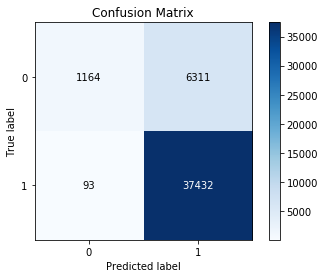

In [48]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,log_loss
import seaborn as sns


clf = LogisticRegression(C=0.05 ,penalty= 'l2')#Here I am using L2 norm
clf.fit(stnd_data_tfidf,y_tr)
y_pred = clf.predict(stnd_data_tfidf_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("logloss on test set: %0.3f%%"%(log_loss(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
skplt.plot_confusion_matrix(y_test,y_pred)

# TFIDF AVG W2V

In [49]:
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [50]:
#AVG TFIDF W2V
tfidf_feat = tf_idf_vect.get_feature_names() 

tfidf_sent_vectors = [];
row=0;
for sent in X_tr["cleaned_data"]: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    #print(sent)
    for word in sent.split(): 
       # print(word)
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tfidf_train[row, tfidf_feat.index(word)]
            tf_idf = dictionary[word]*sent.count(word)
           # print(tf_idf)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
       # print(sent_vec)
    tfidf_sent_vectors.append(sent_vec)
   # print(sent_vec)
    row += 1

In [51]:

tfidf_sent_vectors_test = [];
row=0;
for sent in X_test["cleaned_data"]: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent.split(): 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [52]:

tfidf_sent_vectors_cv = [];
row=0;
for sent in X_cv["cleaned_data"]: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent.split(): 
        #print(word)
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
#print(tfidf_sent_vectors_cv)

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced')
#params we need to try on classifier
params=[]
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l2']}               #here I am using l2 norm
gsv = GridSearchCV(clf,param_grid,cv=10,scoring="f1")#grid_search is used to find the best optimal C
gsv.fit(tfidf_sent_vectors,y_tr)#fit the model only in train dataset
print("Best HyperParameter: ",gsv.best_params_)#the attributes best_params_ gives the Best hyper parameter value
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))#the attribute best_score_ gives the Accuracy of the grid search which gives best C through logistic regression
#print(y_tr.value_counts())
#print(X_tr['Score'].value_counts())
params.append(gsv.best_params_)
C1=params[0]["C"]

Best HyperParameter:  {'C': 0.05, 'penalty': 'l2'}
Best Accuracy: 86.43%


Accuracy on cv set: 77.794%
Precision on cv set: 88.053
Recall on cv set: 77.794
F1-Score on cv set: 80.825
logloss on cv set: 7.670%
Non Zero weights: 50


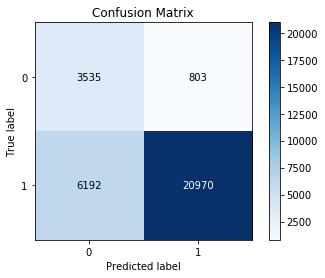

In [54]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,log_loss
import seaborn as sns


clf = LogisticRegression(C=C1 ,penalty= 'l2',class_weight="balanced")#Here I am using L2 norm
clf.fit(tfidf_sent_vectors,y_tr)
y_pred = clf.predict(tfidf_sent_vectors_cv)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("logloss on cv set: %0.3f%%"%(log_loss(y_cv, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
skplt.plot_confusion_matrix(y_cv,y_pred)

K value in Kfold is: 0.05


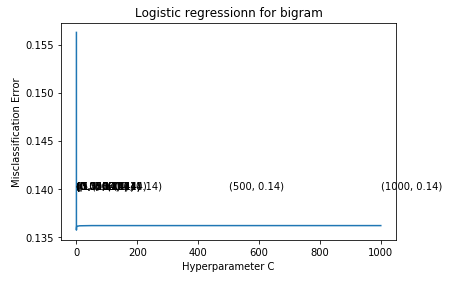

In [55]:
#We gonna find the optimal k by using K fold
cv_score=[]
mylist=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
for k in mylist:# my list contains odd from 1 to 30
    lr=LogisticRegression(C=k,class_weight="balanced")
    score=cross_val_score(lr,tfidf_sent_vectors,y_tr,cv=10,scoring="f1")#here i am using my X and Y as X_tr and y_tr
    #print(score)
    cv_score.append(score.mean())#score gives as 10 score for each odd numbers so we should take score.mean()and store it in cv_score
import matplotlib.pyplot as plt
#print(cv_score)
MSE=[1-x for x in cv_score]
optimal_k = mylist[MSE.index(min(MSE))]
print("K value in Kfold is:",optimal_k)
plt.plot(mylist,MSE)
for xy in zip(mylist, np.round(MSE,2)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel("Hyperparameter C")
plt.ylabel("Misclassification Error")
plt.title("Logistic regressionn for bigram")
plt.show()

Accuracy on test set: 76.129%
Precision on test set: 86.282
Recall on test set: 76.129
F1-Score on test set: 78.886
logloss on test set: 8.245%
Non Zero weights: 50


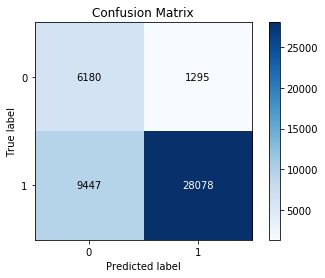

In [56]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,log_loss
import seaborn as sns


clf = LogisticRegression(C=C1 ,penalty= 'l2',class_weight="balanced")#Here I am using L2 norm
clf.fit(tfidf_sent_vectors,y_tr)
y_pred = clf.predict(tfidf_sent_vectors_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("logloss on test set: %0.3f%%"%(log_loss(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
skplt.plot_confusion_matrix(y_test,y_pred)

In [59]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","vectorizer","BEST_Hyperparameter","Trainerror", "Testerror","F1 score(train)","F1(Test)"]

x.add_row(["logistic regression","BOW","C=0.0001","11%","12%","90.24%","89.30%"])
x.add_row(["logistic regression","Bigram","C=0.0001","11%","15%","86.80%","80.04%"])
x.add_row(["logistic regression","AVGW2V","C=0.05","11%","13%","88.16%","86.14%"])
x.add_row(["logistic regression","TFIDF","C=0.0001","11%","15%","86.34%","81.24"])
x.add_row(["logistic regression","AVG TFIDF W2V","C=0.05","23%","24%","80.82%","78.88%"])

print(x)

+---------------------+---------------+---------------------+------------+-----------+-----------------+----------+
|        Model        |   vectorizer  | BEST_Hyperparameter | Trainerror | Testerror | F1 score(train) | F1(Test) |
+---------------------+---------------+---------------------+------------+-----------+-----------------+----------+
| logistic regression |      BOW      |       C=0.0001      |    11%     |    12%    |      90.24%     |  89.30%  |
| logistic regression |     Bigram    |       C=0.0001      |    11%     |    15%    |      86.80%     |  80.04%  |
| logistic regression |     AVGW2V    |        C=0.05       |    11%     |    13%    |      88.16%     |  86.14%  |
| logistic regression |     TFIDF     |       C=0.0001      |    11%     |    15%    |      86.34%     |  81.24   |
| logistic regression | AVG TFIDF W2V |        C=0.05       |    23%     |    24%    |      80.82%     |  78.88%  |
+---------------------+---------------+---------------------+-----------

# Conclusion:
           1)There is an change in pertubation test between before and after adding epsilon,
           2)So the features are co-related(multi collinearity) and also there are 1020 which is greater than 40% of differnce from w1 and w2
           3)BOW featurization is good its gives 90.24% f1 score.
           4)Hyperparameter is differ from gridsearch and random search
           5)Logistic regression is very fast to train model and its one of the good model for this amazon dataset